#### Directories etc

In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode
from scipy.stats import chi2
import subprocess

C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [3]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [4]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [5]:
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)  

In [6]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

In [7]:
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology']]      #Just CDS
mycobrowser_cds_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_cds_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology']))
mycobrowser_cds_boundaries.sort(key = lambda x: x[2])

In [8]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)

In [9]:
def process_blast_output(infile_loc):
    trans = util.Translator()
    blast_results = pd.read_csv(infile_loc, header = None)
    blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'query_length', 'subject_length', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'e_value', 'bit_score']
    for i, r in blast_results.iterrows():
        if '@' in r.query_accession_ver:
            blast_results.at[i, 'query_species'] = (r.query_accession_ver.split('@')[0])
        else:
            blast_results.at[i, 'query_species'] = '_'.join(r.query_accession_ver.split('_')[0:2])
        if '@' in r.subject_accession_ver:
            blast_results.at[i, 'subject_species'] = (r.subject_accession_ver.split('@')[0])
        else:
            blast_results.at[i, 'subject_species'] = '_'.join(r.subject_accession_ver.split('_')[0:2])
    #blast_results = blast_results.query('not (query_species == subject_species)')
    blast_results = blast_results.loc[blast_results.groupby(['query_accession_ver','subject_species'])['bit_score'].idxmax()]
    return blast_results

In [10]:
def keep_reciprocal_best_hits(query_df, reverse_query_df):
    temp_1_dict = {}
    temp_2_dict = {}
    for i, r in query_df.iterrows():
        temp_1_dict[r['query_accession_ver']] = r['subject_accession_ver']
    for i, r in reverse_query_df.iterrows():
        temp_2_dict[r['query_accession_ver']] = r['subject_accession_ver']
    for i, r in query_df.iterrows():
        if temp_1_dict[r['query_accession_ver']] in temp_2_dict and temp_2_dict[temp_1_dict[r['query_accession_ver']]] == r['query_accession_ver']:
            query_df.at[i, 'reciprocal_best_hit'] = 'Y'
        else:
            query_df.at[i, 'reciprocal_best_hit'] = 'N'
    output = query_df[query_df.reciprocal_best_hit == 'Y'] 
    output['species_count'] = output.groupby('query_accession_ver')['query_accession_ver'].transform('size')
    return output

In [11]:
def compass_coverage(start, stop):
    compass_overlap = 0
    for i in range(start, stop):
        if i in compass_dict:
            compass_overlap += 1
    return (compass_overlap/(stop - start))

In [57]:
def show_bin_counts(mutationcounts):
    bin_counts = [0,0,0]
    total_compass_overlap = 0
    for n in range(int(len(mutationcounts)/3)):
        temp_counts = [0,0,0]
        compass_overlap = 0
        for m in range(3): 
            if start+3*n+m in compass_dict:
                compass_overlap += 1
                total_compass_overlap += 1
            temp_counts[m % 3] = mutationcounts[3*n+m]
        if sum(temp_counts) < 10 and compass_overlap == 0:
            for m in range(3):
                bin_counts[m] += temp_counts[m]
    return (bin_counts, sum(bin_counts)/len(mutation_counts), total_compass_overlap / len(mutation_counts))

In [195]:
def score_region(mutationcounts, start):
    bin_counts = [0,0,0]
    for n in range(int(len(mutationcounts)/3)):
        temp_counts = [0,0,0]
        compass_overlap = 0
        for m in range(3): 
            if start+3*n+m in compass_dict:
                compass_overlap = 1
            temp_counts[m % 3] = mutationcounts[3*n+m]
        if sum(temp_counts) < 10 and compass_overlap == 0:
            for m in range(3):
                bin_counts[m] += temp_counts[m]
    return bin_formula(bin_counts[2], sum(bin_counts))

#### Mycobrowswer annotated CDS regions

[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

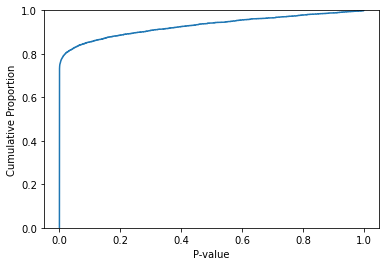

In [52]:
scores =[]
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries: 
    if compass_coverage(start, stop) > 0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores.append(score_region(mutation_counts_2, start))
    #if score_region(mutation_counts_2) < 0.5:
    #    print(locus, show_bin_counts(mutation_counts_2))
a = sns.ecdfplot(scores)
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [56]:
len([x for x in scores if x < 0.0000001])/len(scores)

0.6500920810313076

####  Random positions

In [58]:
unmasked_zero_and_non_zero_mutation_counts = []
for n, c in tqdm(enumerate(full_sample_zero_and_non_zero_mutation_counts)):
    if n in compass_dict:
        continue
    else:
        unmasked_zero_and_non_zero_mutation_counts.append(c)
len(unmasked_zero_and_non_zero_mutation_counts)

4411532it [00:01, 3187418.10it/s]


4086561

In [59]:
sum(unmasked_zero_and_non_zero_mutation_counts)/len(unmasked_zero_and_non_zero_mutation_counts)

1.9051026033870533

[7]


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

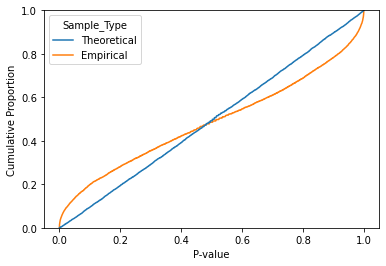

In [106]:
scores_2 = []
for x in range(10000):
    sample = random.sample(unmasked_zero_and_non_zero_mutation_counts, 1000)
    tot = sum(sample)
    r = binom.rvs(tot, 1/3, size=1)[0]
    s = tot - r
    scores_2.append(['Theoretical', bin_formula(r, tot)])
    scores_2.append(['Empirical', score_region(sample, 0)])
temp = pd.DataFrame(scores_2, columns = ['Sample_Type','Score'])
a = sns.ecdfplot(data = temp, x = 'Score', hue = 'Sample_Type')
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')
#plt.xscale('log')

In [107]:
scores_2.sort()
scores_2[int(10000 * 0.01)]

['Empirical', 0.00014186168596275195]

TypeError: 'NoneType' object is not iterable

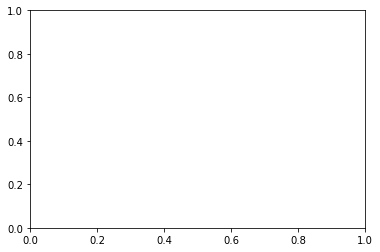

In [101]:
a = sns.ecdfplot(scores_2)
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')
plt.xscale('log')

#### Intergenic MORFs

In [45]:
min_intergenic_length = 50
candidate_intergenic_morfs = []
max_stop = 0
ORFFinder = orffn.ORF_Finder(full_sequence)
for n,cds in enumerate(mycobrowser_cds_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_cds_boundaries) - 1:
        if mycobrowser_cds_boundaries[n+1][2] > max_stop + min_intergenic_length:
            a =ORFFinder.max_orf(max_stop-10, mycobrowser_cds_boundaries[n+1][2]+10, output_orfs = 'Nested', min_orf_length = min_intergenic_length)
            for x in a:
                candidate_intergenic_morfs.append(x)

In [1]:
scores_4 =[]
for (start, stop, strand, length) in candidate_intergenic_morfs: 
    if compass_coverage(start, stop) > 0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores_4.append([(start, stop, strand, length),score_region(mutation_counts_2, start)])
a = sns.ecdfplot([x[1] for x in scores_4])
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')
#plt.xscale('log')

NameError: name 'candidate_intergenic_morfs' is not defined

#### All MORFs

In [72]:
min_intergenic_length = 50
candidate_morfs = []
ORFFinder = orffn.ORF_Finder(full_sequence)
a =ORFFinder.max_orf(0, len(full_sequence)-1, output_orfs = 'Nested', min_orf_length = min_intergenic_length)
for x in a:
    candidate_morfs.append(x)

In [74]:
len(candidate_morfs)

63720

#### Eliminate negative strand instances where they would have same pattern of 3rd codon 

In [75]:
candidate_morfs.sort(key = lambda x: x[3], reverse = True)
maximal_reading_frame_orfs = [candidate_morfs[0]]
for n, morf in tqdm(enumerate(candidate_morfs)):
    if n==0:
        continue
    overlap = 0
    for m, morf2 in enumerate(candidate_morfs):
        if m == n and overlap == 0:
            maximal_reading_frame_orfs.append(morf)
            break
        else:
            if morf2[0] <= morf[0] and morf2[1] >= morf[1]:
                if morf2[2] == morf[2]:
                    if (morf2[1] - morf[1])%3 == 0:
                        overlap = 1
                        break
                else:
                    if (morf2[0] + 2- morf[0])%3 == 0:
                        overlap = 1
                        break        

63720it [06:04, 174.98it/s] 


##### Classify remaining ORFs into annotated, intergenic or overlapping

In [76]:
new_annotation_features_dict = {}
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries:
    if strand == 1:
        new_annotation_features_dict[stop] = (locus, product, start, stop, strand)
    else:
        new_annotation_features_dict[start] = (locus, product, start, stop, strand)

100%|██████████| 42441/42441 [00:20<00:00, 2053.14it/s]


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

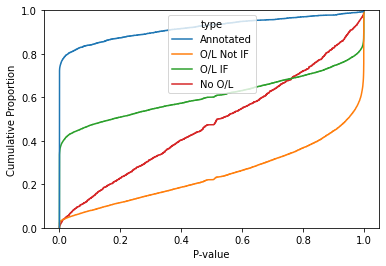

In [133]:
temp = []
for (start, stop, strand, length) in tqdm(maximal_reading_frame_orfs):
    if compass_coverage(start, stop)>0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        score = score_region(mutation_counts, start)
    else:
        score = score_region(list(reversed(mutation_counts)), start)
  
#    if (strand == 1 and stop in new_annotation_features_dict) or (strand == -1 and start in new_annotation_features_dict):
    if (strand == 1 and stop in new_annotation_features_dict and new_annotation_features_dict[stop][4] == 1) or (strand == -1 and start in new_annotation_features_dict and new_annotation_features_dict[start][4] == -1):
        temp.append(['Annotated', score, (start, stop, strand, length)])
    else:
        overlap = 0
        for cds in mycobrowser_cds_boundaries:
            if (cds[2] <= start and cds[3] >= start) or (cds[2] <= stop and cds[3] >= stop):
                overlap = 1
                break
        if overlap == 1:
            if (cds[4] == strand and (cds[2] - start)%3 == 0) or (not(cds[4] == strand) and (cds[2] - start)%3 == 2):
                temp.append(['O/L IF', score, (start, stop, strand, length)])
            else:
                temp.append(['O/L Not IF', score, (start, stop, strand, length)])
        else:
            temp.append(['No O/L', score, (start, stop, strand, length)])
morf_df = pd.DataFrame(temp, columns = ['type','score','location'])
a = sns.ecdfplot(data = morf_df, x = 'score', hue = 'type')
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [134]:
len(morf_df)

39726

In [138]:
len(morf_df[morf_df['type'] =='No O/L'])

2451

#### Upstream starts

100%|██████████| 42441/42441 [00:10<00:00, 4113.56it/s]


[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

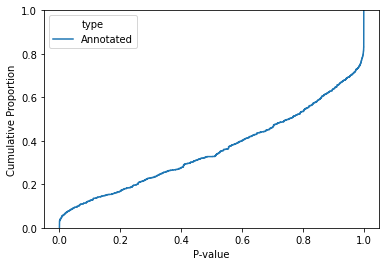

In [196]:
temp = []
for (start, stop, strand, length) in tqdm(maximal_reading_frame_orfs):
    if compass_coverage(start, stop)>0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        score = score_region(mutation_counts, start)
    else:
        score = score_region(list(reversed(mutation_counts)), start)
  
    if (strand == 1 and stop in new_annotation_features_dict and new_annotation_features_dict[stop][4] == 1) or (strand == -1 and start in new_annotation_features_dict and new_annotation_features_dict[start][4] == -1):
        if (strand == 1 and stop in new_annotation_features_dict):
            dict_entry = new_annotation_features_dict[stop][2:4]
            locus = new_annotation_features_dict[stop][0]
        else:
            dict_entry = new_annotation_features_dict[start][2:4]
            locus = new_annotation_features_dict[start][0]
        if strand == 1 and start < dict_entry[0]:
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[dict_entry[0]:stop]
            score = score_region(mutation_counts, dict_entry[0])
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:dict_entry[0]]
            score_2 = score_region(mutation_counts, start)
            temp.append(['Annotated', score, score_2, (start, stop, strand, length), dict_entry, locus ])
        if strand == -1 and stop > dict_entry[1]:
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:dict_entry[1]]
            score = score_region(list(reversed(mutation_counts)), dict_entry[1])
            mutation_counts = full_sample_zero_and_non_zero_mutation_counts[dict_entry[1]:stop]
            score_2 = score_region(list(reversed(mutation_counts)), dict_entry[1])
            temp.append(['Annotated', score, score_2, (start, stop, strand, length), dict_entry, locus ])
upstream_df = pd.DataFrame(temp, columns = ['type','annotation_score','upstream_score','morf_location','annotation_location','Locus'])
a = sns.ecdfplot(data = upstream_df, x = 'upstream_score', hue = 'type')
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [197]:
dejesus_df = pd.read_csv(project_dir + '/DeJesus.csv')
dejesus_df

,ORF,Score,Offset
0,Rv0001,0.000,0
1,Rv0002,0.000,0
2,Rv0003,0.000,0
3,Rv0004,0.000,0
4,Rv0005,-1.782,39
...,...,...,...
3526,Rv3919c,0.000,0
3527,Rv3920c,0.000,0
3528,Rv3921c,0.000,0
3529,Rv3922c,-0.624,10


In [198]:
temp = upstream_df[upstream_df['upstream_score'] < 0.001]
temp.sort_values(by=['Locus'], inplace=True)
temp_2 = temp.merge(dejesus_df, how='left', left_on='Locus', right_on='ORF');

In [199]:
for i, r in temp_2.iterrows():
    if r['Score'] < -0.7:
        if r['morf_location'][2] == 1:
            temp_2.at[i,'DeJesus_Proposal'] = (r['annotation_location'][0] + int(r['Offset'])*3, r['annotation_location'][1])
        elif r['morf_location'][2] == -1:
            temp_2.at[i,'DeJesus_Proposal'] = (r['annotation_location'][0], r['annotation_location'][1] + int(r['Offset'])*3)
    else:
        temp_2.at[i,'DeJesus_Proposal'] = ""


In [200]:
cols = ['Locus', 'upstream_score', 'annotation_location', 'morf_location', 'DeJesus_Proposal']
temp_2 = temp_2[cols]
temp_2
temp_2.to_csv(project_dir+'/Reannotation_upstream_scores.csv')

In [201]:
temp_2

,Locus,upstream_score,annotation_location,morf_location,DeJesus_Proposal
0,Rv0010c,8.152109e-04,"(13132, 13558)","(13132, 13591, -1, 456)",
1,Rv0230c,1.847569e-07,"(274982, 275963)","(274982, 276230, -1, 1245)",
2,Rv0231,4.637381e-04,"(276057, 277764)","(275874, 277764, 1, 1887)",
3,Rv0361,3.811302e-04,"(438821, 439649)","(438536, 439649, 1, 1110)",
4,Rv0496,1.385425e-11,"(586393, 587380)","(586345, 587380, 1, 1032)","(586345, 587380)"
5,Rv0653c,1.383018e-04,"(749233, 749929)","(749233, 750106, -1, 870)",
6,Rv0759c,2.401234e-07,"(853824, 854157)","(853824, 854226, -1, 399)","(853824, 854088)"
7,Rv0774c,1.819422e-11,"(867439, 868351)","(867439, 868558, -1, 1116)",
8,Rv0786c,1.572891e-09,"(881074, 881464)","(881074, 882091, -1, 1014)",
9,Rv0863,0.000000e+00,"(962598, 962880)","(962205, 962880, 1, 672)","(962679, 962880)"


#### Intergenic regions

In [24]:
temp = []
min_intergenic_length = 20
intergenic_regions = []
max_stop = 0
ORFFinder = orffn.ORF_Finder(full_sequence)
for n,cds in enumerate(mycobrowser_cds_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_cds_boundaries) - 1:
        if mycobrowser_cds_boundaries[n+1][2] > max_stop + min_intergenic_length and compass_coverage(max_stop, mycobrowser_cds_boundaries[n+1][2]) == 0:
            intergenic_regions.append([max_stop, mycobrowser_cds_boundaries[n+1][2]])
for [start, stop] in intergenic_regions:
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]#
    temp.append((start, stop, sum([x for x in mutation_counts if x < 10]) / (len([x for x in mutation_counts if x < 10]))))

<AxesSubplot:ylabel='Count'>

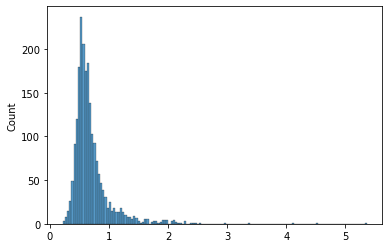

In [25]:
sns.histplot([x[2] for x in temp])

In [ ]:
longest_chain_lengths = []
for (start, stop, ave) in temp:
    longest_chain = 0
    chain_started = False
    co_ords = (0,0)
    for i in range(start, stop):
        if full_sample_zero_and_non_zero_mutation_counts[i] == 0:
            if chain_started == False:
                chain_start = i
                chain_started = True
            else:
                pass
        else:
            if chain_started == True:
                if i - chain_start > longest_chain:
                    longest_chain = i - chain_start
                    co_ords = (chain_start, i)
                chain_started = False
    longest_chain_lengths.append(longest_chain)
    if longest_chain > 20:
        print(start, stop, longest_chain, co_ords, ave)

In [ ]:
print(full_sample_zero_and_non_zero_mutation_counts[3414958:3415434])

In [ ]:
print(sum([x for x in full_sample_zero_and_non_zero_mutation_counts if x <10])/len([x for x in full_sample_zero_and_non_zero_mutation_counts if x <10]))

In [ ]:
print(util.reverse_complement(full_sequence[3414958:3415434]))

In [ ]:
sns.histplot(longest_chain_lengths)

#### Produce FASTA file of annotated proteins and another FASTA file of low p-value MORFs which don't match known CDSs 

In [ ]:
trns = util.Translator()
mycobrowser_proteins = []
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries:
    protein_seq = trns.translate_sequence(full_sequence[start:stop],strand,0)
    mycobrowser_proteins.append(['NC_000962.3@'+str(start)+'_'+str(stop)+'_'+str(strand), protein_seq[:-1]])
util.produce_fasta_file(mycobrowser_proteins, project_dir + '/mycobrowser_proteins.faa')

In [ ]:
trns = util.Translator()
other_sense_morfs = []
for morf in maximal_reading_frame_orfs:
    strand = morf[0][2]
    start = morf[0][0]
    stop = morf[0][1]
    annotated_feature = ''
    if strand == 1 and stop in new_annotation_features_dict:
        annotated_feature = new_annotation_features_dict[stop]
    if strand == -1 and start in new_annotation_features_dict:
        annotated_feature = new_annotation_features_dict[start]
    if annotated_feature == '' and morf[1] == 0:
        protein_seq = trns.translate_sequence(full_sequence[morf[0][0]:morf[0][1]],morf[0][2],0)
        other_sense_morfs.append(['NC_000962.3@'+str(morf[0][0])+'_'+str(morf[0][1])+'_'+str(morf[0][2]), protein_seq[:-1]])

In [ ]:
util.produce_fasta_file(other_sense_morfs, project_dir + '/other_sense_morfs.faa')

In [ ]:
if 1==0:
#if full_run == True:
    w_d = os.getcwd()
    os.chdir("F:/")
    subprocess.run('cd '+ project_dir + ' &  makeblastdb -in mycobrowser_proteins.faa -dbtype prot -out mycobrowser_prot', shell=True, capture_output = True)
    os.chdir(w_d)

In [ ]:
if 1==0:
#if full_run == True:
    w_d = os.getcwd()
    os.chdir("F:/")
    subprocess.run('cd '+ project_dir + ' &  makeblastdb -in other_sense_morfs.faa -dbtype prot -out other_sense_morf_prot', shell=True, capture_output = True)
    os.chdir(w_d)

In [ ]:
if 1==0:
#if full_run == True:
    w_d = os.getcwd()
    os.chdir("F:/")
    subprocess.run('cd f:\\Datasets\\BLAST\\subj_prot & blastp -query other_sense_morfs.faa -db subj_prot -out blastp_results_other_sense_morfs_query_subject.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    subprocess.run('cd f:\\Datasets\\BLAST\\other_sense_morf_prot & blastp -query subject_proteins.faa -db other_sense_morf_prot -out blastp_results_subject_no_orf_query.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    os.chdir(w_d)

In [ ]:
if 1==0:
#if full_run == True:
    w_d = os.getcwd()
    os.chdir("F:/")
    subprocess.run('cd f:\\Datasets\\BLAST\\subj_prot & blastp -query mycobrowser_proteins.faa -db subj_prot -out blastp_results_mycobrowser_proteins_query_subject.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    subprocess.run('cd f:\\Datasets\\BLAST\\mycobrowser_prot & blastp -query subject_proteins.faa -db mycobrowser_prot -out blastp_results_subject_no_orf_query.csv -evalue 1e-7 -seg no -outfmt  "10 qaccver saccver qlen slen pident length mismatch gapopen qstart qend sstart send evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    os.chdir(w_d)

#### Establish reciprocal best hits in annotated CDS and other sense ORFs

In [28]:
blast_results_1 = process_blast_output('f:/Datasets/BLAST/subj_prot/blastp_results_other_sense_morfs_query_subject.csv')
blast_results_2 = process_blast_output('f:/Datasets/BLAST/other_sense_morf_prot/blastp_results_subject_no_orf_query.csv')

In [29]:
temp_df = keep_reciprocal_best_hits(blast_results_1, blast_results_2)

In [30]:
blast_results_3 = process_blast_output('f:/Datasets/BLAST/subj_prot/blastp_results_mycobrowser_proteins_query_subject.csv')
blast_results_4 = process_blast_output('f:/Datasets/BLAST/mycobrowser_prot/blastp_results_subject_no_orf_query.csv')

In [31]:
temp_df_2 = keep_reciprocal_best_hits(blast_results_3, blast_results_4)

In [ ]:
test_1 = temp_df[['query_accession_ver','species_count']].drop_duplicates()
test_2 = temp_df_2[['query_accession_ver','species_count']].drop_duplicates()

In [ ]:
for i, r in test_1.iterrows():
    pos = r['query_accession_ver'].split('@')[1].split('_')
    test_1.at[i, 'start'] = int(pos[0])
    test_1.at[i, 'stop'] = int(pos[1])
    test_1.at[i, 'strand'] = int(pos[2])

In [ ]:
for i, r in test_2.iterrows():
    pos = r['query_accession_ver'].split('@')[1].split('_')
    test_2.at[i, 'start'] = int(pos[0])
    test_2.at[i, 'stop'] = int(pos[1])
    test_2.at[i, 'strand'] = int(pos[2])

In [ ]:
test_1=test_1.sort_values(by='start') 
test_2=test_2.sort_values(by='start') 

In [ ]:
test_1.to_csv(project_dir +'/test_1.csv')
test_2.to_csv(project_dir +'/test_2.csv')

In [26]:
test_1 = pd.read_csv(project_dir +'/test_1.csv')
test_2 = pd.read_csv(project_dir +'/test_2.csv')

In [ ]:
for i, r in test_1.iterrows():
    (query_ref_1, num_1, start_1, stop_1) = (r['query_accession_ver'], r['species_count'], r['start'], r['stop'])
    unmatched = 0
    for j, s in test_2.iterrows():
        (query_ref_2, num_2, start_2, stop_2) = (s['query_accession_ver'], s['species_count'], s['start'], s['stop'])
        if (start_2 <= start_1 and stop_2 >= stop_1):
            print(query_ref_1, num_1, query_ref_2, num_2)
            temp_1 = blast_results_1.query("query_accession_ver == @query_ref_1")
            hit_species_1 = set(list(temp_1['subject_species'].unique()))
            ave_perc_id_1 = 0
            for i, r in temp_1.iterrows():
                ave_perc_id_1 += r['percent_identical_matches']
            ave_perc_id_1 = ave_perc_id_1 / len(temp_1)
            temp_2 = blast_results_3.query("query_accession_ver == @query_ref_2")
            hit_species_2 = set(list(temp_2['subject_species'].unique()))
            ave_perc_id_2 = 0
            for i, r in temp_2.iterrows():
                ave_perc_id_2 += r['percent_identical_matches']
            ave_perc_id_2 = ave_perc_id_2 / len(temp_2)
            print(ave_perc_id_1, ave_perc_id_2, hit_species_1.difference(hit_species_2))
            unmatched =  1
            break
    if unmatched == 0:
        print('Unmatched',query_ref_1, num_1)
        temp_1 = blast_results_1.query("query_accession_ver == @query_ref_1")
        ave_perc_id_1 = 0
        for i, r in temp_1.iterrows():
            ave_perc_id_1 += r['percent_identical_matches']
        ave_perc_id_1 = ave_perc_id_1 / len(temp_1)
        print(ave_perc_id_1)

In [60]:
score_region(list(reversed(full_sample_zero_and_non_zero_mutation_counts[2124829+3:2125048-3])),2124829+3)

4.475309012264006e-13

In [20]:
tr = util.Translator()
tr.translate_sequence(full_sequence[547075:547357],-1,0)

'MLRGEIWQVDLDPARGSAANMRRPAVIVSNDRANAAAIRLDRGVVPVVPVTSNTEKVPIPGVVAGSERWPGRRFEGAGPAGWIRRCATSPLPS*'

In [24]:
mutation_counts = list(reversed(full_sample_zero_and_non_zero_mutation_counts[547034:547357]))

In [26]:
score_region(mutation_counts, 547034)

0.9597027769407592

In [ ]:
score_region(mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores.append(score_region(mutation_counts_2, start))